In [36]:
import os
os.environ["PYTORCH_DISABLE_NNPACK"] = "1"
import glob
import json
import tarfile
import shutil
from dask.distributed import Client, LocalCluster
import gc
from dask.distributed import as_completed, get_worker
import dask.bag as db
import torch
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import numpy as np
from dask import delayed, compute
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "cct_data"
IMG_TAR  = os.path.join(DATA_DIR, "eccv_18_all_images_sm.tar.gz")
ANN_TAR  = os.path.join(DATA_DIR, "eccv_18_annotations.tar.gz")

EXTRACT_DIR = os.path.join(DATA_DIR, "extracted")
os.makedirs(EXTRACT_DIR, exist_ok=True)

def extract_tar_once(tar_path, out_dir):
    marker = os.path.join(out_dir, f".extracted_{os.path.basename(tar_path)}")
    if os.path.exists(marker):
        print("Already extracted:", tar_path)
        return
    print("Extracting:", tar_path, "->", out_dir)
    with tarfile.open(tar_path, "r:gz") as tf:
        tf.extractall(out_dir)
    open(marker, "w").close()
    print("Done.")

extract_tar_once(IMG_TAR, EXTRACT_DIR)
extract_tar_once(ANN_TAR, EXTRACT_DIR)

jsons = sorted(glob.glob(os.path.join(EXTRACT_DIR, "**", "*.json"), recursive=True))
jpgs  = sorted(glob.glob(os.path.join(EXTRACT_DIR, "**", "*.jpg"), recursive=True))
IMG_ROOT = os.path.commonpath(jpgs)

print("EXTRACT_DIR:", EXTRACT_DIR)
print("Top-level extracted:", os.listdir(EXTRACT_DIR))
print("JSON count:", len(jsons), "first:", jsons[:3])
print("JPG count:", len(jpgs), "first:", jpgs[:3])

Already extracted: cct_data/eccv_18_all_images_sm.tar.gz
Already extracted: cct_data/eccv_18_annotations.tar.gz
EXTRACT_DIR: cct_data/extracted
Top-level extracted: ['.extracted_eccv_18_annotations.tar.gz', 'eccv_18_annotation_files', '.extracted_eccv_18_all_images_sm.tar.gz', 'eccv_18_all_images_sm']
JSON count: 5 first: ['cct_data/extracted/eccv_18_annotation_files/cis_test_annotations.json', 'cct_data/extracted/eccv_18_annotation_files/cis_val_annotations.json', 'cct_data/extracted/eccv_18_annotation_files/train_annotations.json']
JPG count: 57864 first: ['cct_data/extracted/eccv_18_all_images_sm/5858bf2b-23d2-11e8-a6a3-ec086b02610b.jpg', 'cct_data/extracted/eccv_18_all_images_sm/5858bf2c-23d2-11e8-a6a3-ec086b02610b.jpg', 'cct_data/extracted/eccv_18_all_images_sm/5858bf33-23d2-11e8-a6a3-ec086b02610b.jpg']


In [3]:
ANN_FILE = jsons[0]
IMG_ROOT = os.path.commonpath(jpgs)

with open(ANN_FILE, "r") as f:
    ann = json.load(f)

sample = ann["images"][0]["file_name"]

print("ANN_FILE:", ANN_FILE)
print("IMG_ROOT:", IMG_ROOT)
print("Sample file_name:", sample)
print("Sample exists:", os.path.exists(os.path.join(IMG_ROOT, sample)))

ANN_FILE: cct_data/extracted/eccv_18_annotation_files/cis_test_annotations.json
IMG_ROOT: cct_data/extracted/eccv_18_all_images_sm
Sample file_name: 59b93afb-23d2-11e8-a6a3-ec086b02610b.jpg
Sample exists: True


In [ ]:
if not jsons:
    raise RuntimeError("No JSON files found in annotations.")

sizes = [(f, os.path.getsize(f)) for f in jsons]
sizes_sorted = sorted(sizes, key=lambda x: x[1], reverse=True)

main_json = sizes_sorted[0][0]
print("Picked MAIN annotation JSON: ", main_json, "size=", sizes_sorted[0][1])

split_candidates = [f for f in jsons if "split" in os.path.basename(f).lower()]
splits_json = split_candidates[0] if split_candidates else None
print("Picked SPLITS JSON: ", splits_json)

with open(main_json, "r") as f:
    ann = json.load(f)

print("Top-level keys in main JSON: ", list(ann.keys())[:20])

In [5]:
#build table

images_key = "images" if "images" in ann else None
annotations_key = "annotations" if "annotations" in ann else None
categories_key = "categories" if "categories" in ann else None

if not (images_key and annotations_key and categories_key):
    raise RuntimeError(f"Unexpected JSON structure. Keys found: {ann.keys()}")

images = ann[images_key]
annotations = ann[annotations_key]
categories = ann[categories_key]

cat_id_to_name = {c["id"]: c.get("name", str(c["id"])) for c in categories}

#image_id -> metadata
img_by_id = {im["id"]: im for im in images}

rows = []
for a in annotations:
    img_id = a["image_id"]
    im = img_by_id.get(img_id, {})
    file_name = im.get("file_name") or im.get("filename") or im.get("path")

    location = im.get("location") or im.get("location_id") or im.get("site") or im.get("camera")
    dt = im.get("datetime") or im.get("date_time") or im.get("timestamp") or im.get("date")

    cat_id = a.get("category_id")
    species = cat_id_to_name.get(cat_id, str(cat_id))

    rows.append({
        "image_id": img_id,
        "file_name": file_name,
        "species": species,
        "category_id": cat_id,
        "location": location,
        "datetime": dt,
    })

df = pd.DataFrame(rows)
df["abs_path"] = df["file_name"].apply(lambda p: os.path.join(IMG_ROOT, p) if isinstance(p, str) else None)

#drop rows without a valid path
df = df[df["abs_path"].notna()]
df = df[df["abs_path"].apply(os.path.exists)]

print("Rows:", len(df))
print(df.head())
print("Unique species:", df["species"].nunique())

Rows: 24028
                               image_id  \
0  5a27d8d5-23d2-11e8-a6a3-ec086b02610b   
1  59e77d7d-23d2-11e8-a6a3-ec086b02610b   
2  59be3ef9-23d2-11e8-a6a3-ec086b02610b   
3  59bac733-23d2-11e8-a6a3-ec086b02610b   
4  596eedaf-23d2-11e8-a6a3-ec086b02610b   

                                  file_name  species  category_id  location  \
0  5a27d8d5-23d2-11e8-a6a3-ec086b02610b.jpg      cat           16      40.0   
1  59e77d7d-23d2-11e8-a6a3-ec086b02610b.jpg      cat           16      40.0   
2  59be3ef9-23d2-11e8-a6a3-ec086b02610b.jpg  raccoon            3      40.0   
3  59bac733-23d2-11e8-a6a3-ec086b02610b.jpg      cat           16      40.0   
4  596eedaf-23d2-11e8-a6a3-ec086b02610b.jpg  raccoon            3      40.0   

  datetime                                           abs_path  
0     None  cct_data/extracted/eccv_18_all_images_sm/5a27d...  
1     None  cct_data/extracted/eccv_18_all_images_sm/59e77...  
2     None  cct_data/extracted/eccv_18_all_images_sm/59be3... 

In [6]:
df["split"] = "unknown"

if splits_json:
    with open(splits_json, "r") as f:
        splits = json.load(f)

    if isinstance(splits, dict) and any(k in splits for k in ["train", "val", "test"]):
        print("var1")
        for sp in ["train", "val", "test"]:
            if sp in splits and isinstance(splits[sp], list):
                df.loc[df["image_id"].isin(splits[sp]), "split"] = sp

    if "splits" in splits and isinstance(splits["splits"], dict):
        for sp in ["train", "val", "test"]:
            if sp in splits["splits"]:
                df.loc[df["image_id"].isin(splits["splits"][sp]), "split"] = sp

print(df["split"].value_counts())

split
unknown    24028
Name: count, dtype: int64


In [7]:
#subset

#remove empty/background classes if present
bad = set(["empty", "blank", "no_animal", "none", "car"])
df_use = df[~df["species"].str.lower().isin(bad)].copy()

#top-K species by frequency
TOP_K = 10
top_species = df_use["species"].value_counts().head(TOP_K).index.tolist()
df_use = df_use[df_use["species"].isin(top_species)].copy()

#cap images per species to keep training fast
CAP_PER_SPECIES = 1500
df_use = (df_use.groupby("species", group_keys=False)
          .apply(lambda g: g.sample(min(len(g), CAP_PER_SPECIES), random_state=42))
          .reset_index(drop=True))

print("Using rows:", len(df_use))
print(df_use["species"].value_counts())

Using rows: 11075
species
bobcat      1500
cat         1500
opossum     1500
coyote      1500
raccoon     1500
dog         1057
squirrel    1052
rabbit       871
skunk        333
bird         262
Name: count, dtype: int64


/tmp/ipykernel_1904/3113759873.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), CAP_PER_SPECIES), random_state=42))


In [8]:
#Dask DataFrame summary
ddf = dd.from_pandas(df_use[["species", "location"]], npartitions=4)
print("Dask species counts (top 10): ")
print(ddf["species"].value_counts().compute().head(10))

Dask species counts (top 10): 
species
cat         1500
skunk        333
squirrel    1052
bobcat      1500
dog         1057
rabbit       871
bird         262
raccoon     1500
coyote      1500
opossum     1500
Name: count, dtype: int64[pyarrow]


In [9]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    processes=False,
    memory_limit="2GB"
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.2.15:8787/status,
Dashboard: http://10.0.2.15:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://10.0.2.15/1904/1,Workers: 0
Dashboard: http://10.0.2.15:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.0.2.15/1904/4,Total threads: 2
Dashboard: http://10.0.2.15:42359/status,Memory: 1.86 GiB
Nanny: None,


2026-01-28 12:55:07,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.34 GiB -- Worker memory limit: 1.86 GiB
2026-01-28 13:00:20,626 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.31 GiB -- Worker memory limit: 1.86 GiB
2026-01-28 13:05:23,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [10]:
#feature extraction - ResNet18

device = "cpu"
torch.set_num_threads(2)

#lazy init per worker
def _get_embedder():
    w = get_worker()
    if not hasattr(w, "_cct_embedder"):
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        model.fc = torch.nn.Identity()
        model.eval().to(device)
        preprocess = weights.transforms()
        w._cct_embedder = (model, preprocess)
    return w._cct_embedder

@torch.no_grad()
def embed_batch(batch_paths):
    model, preprocess = _get_embedder()
    imgs = []
    for p in batch_paths:
        with Image.open(p) as im:
            im = im.convert("RGB")
            imgs.append(preprocess(im))
    x = torch.stack(imgs, dim=0).to(device)
    z = model(x).cpu().numpy().astype("float32")  #(batch, 512)
    return z

paths  = df_use["abs_path"].tolist()
labels = df_use["species"].tolist()
N = len(paths)

BATCH = 16
batches = [(i, paths[i:i+BATCH]) for i in range(0, N, BATCH)]

#output
out_dir = os.path.join(DATA_DIR, "features")
os.makedirs(out_dir, exist_ok=True)

emb_path = os.path.join(out_dir, "resnet18_embeds.float32.mmap")
lab_path = os.path.join(out_dir, "labels.npy")

X_mm = np.memmap(emb_path, dtype="float32", mode="w+", shape=(N, 512))
np.save(lab_path, np.array(labels, dtype=object))

#submit a small number of tasks at a time
MAX_INFLIGHT = 2

it = iter(batches)
ac = as_completed()
inflight = {}

def submit_next():
    try:
        i0, b0 = next(it)
    except StopIteration:
        return False
    fut = client.submit(embed_batch, b0, pure=False)
    inflight[fut] = i0
    ac.add(fut)
    return True

for _ in range(MAX_INFLIGHT):
    if not submit_next():
        break

done = 0
while inflight:
    fut = next(ac)
    i0 = inflight.pop(fut)
    z = fut.result()

    X_mm[i0:i0+len(z)] = z
    X_mm.flush()

    done += len(z)
    if done % (BATCH * 20) == 0:
        print(f"done {done}/{N}")

    del z
    gc.collect()

    submit_next()

print("Saved embeddings:", emb_path)
print("Saved labels:", lab_path)
print("Embedding shape:", (N, 512))

done 320/11075
done 640/11075
done 960/11075
done 1280/11075
done 1600/11075
done 1920/11075
done 2240/11075
done 2560/11075
done 2880/11075
done 3200/11075
done 3520/11075
done 3840/11075
done 4160/11075
done 4480/11075
done 4800/11075
done 5120/11075
done 5440/11075
done 5760/11075
done 6080/11075
done 6400/11075
done 6720/11075
done 7040/11075
done 7360/11075
done 7680/11075
done 8000/11075
done 8320/11075
done 8640/11075
done 8960/11075
done 9280/11075
done 9600/11075
done 9920/11075
done 10240/11075
done 10560/11075
done 10880/11075
Saved embeddings: cct_data/features/resnet18_embeds.float32.mmap
Saved labels: cct_data/features/labels.npy
Embedding shape: (11075, 512)


In [13]:
#train + eval

emb_path = os.path.join(DATA_DIR, "features", "resnet18_embeds.float32.mmap")
lab_path = os.path.join(DATA_DIR, "features", "labels.npy")

labels = np.load(lab_path, allow_pickle=True)

N = len(labels)
X = np.memmap(emb_path, dtype="float32", mode="r", shape=(N, 512))
y = labels

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, n_jobs=-1)
)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=le.classes_))

              precision    recall  f1-score   support

        bird       0.85      0.77      0.81        52
      bobcat       0.58      0.59      0.59       300
         cat       0.82      0.80      0.81       300
      coyote       0.71      0.69      0.70       300
         dog       0.93      0.92      0.93       211
     opossum       0.65      0.68      0.67       300
      rabbit       0.75      0.78      0.76       174
     raccoon       0.74      0.72      0.73       300
       skunk       0.75      0.75      0.75        67
    squirrel       0.90      0.95      0.93       211

    accuracy                           0.75      2215
   macro avg       0.77      0.76      0.77      2215
weighted avg       0.75      0.75      0.75      2215



In [14]:
df_use.loc[df_use["datetime"].notna(), "datetime"].head(5)


Series([], Name: datetime, dtype: object)

Datetime is missing in this subset; skipping month/hour analysis.


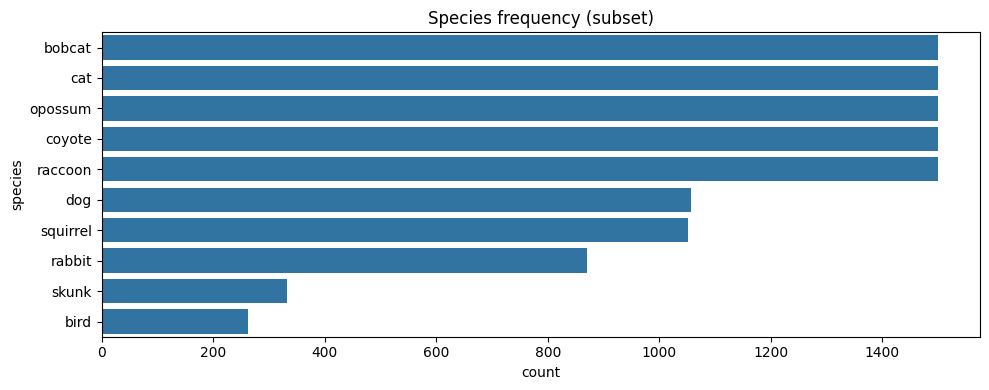

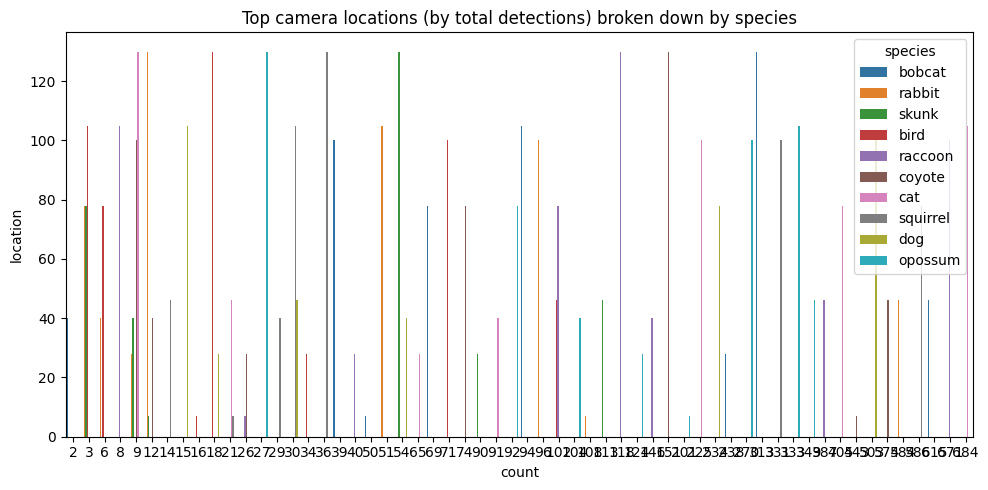

In [15]:
#pattern analysis

df_pat = df_use.copy()

#parse datetime
df_pat["datetime"] = pd.to_datetime(df_pat["datetime"], errors="coerce")

has_time = df_pat["datetime"].notna().any()
if has_time:
    df_pat["month"] = df_pat["datetime"].dt.month
    df_pat["hour"]  = df_pat["datetime"].dt.hour
else:
    print("Datetime is missing in this subset; skipping month/hour analysis.")

#1. species frequency
plt.figure(figsize=(10,4))
sns.countplot(data=df_pat, y="species", order=df_pat["species"].value_counts().index)
plt.title("Species frequency (subset)")
plt.tight_layout()
plt.show()

#2. seasonal/monthly occurrences
if has_time:
    monthly = df_pat.dropna(subset=["datetime"]).groupby([df_pat["datetime"].dt.month, "species"]).size().reset_index(name="count")
    monthly = monthly.rename(columns={"datetime": "month"}).rename(columns={monthly.columns[0]:"month"})
    plt.figure(figsize=(10,4))
    sns.lineplot(data=monthly, x="month", y="count", hue="species", marker="o")
    plt.title("Monthly occurrences by species")
    plt.xticks(range(1,13))
    plt.tight_layout()
    plt.show()

#3. time-of-day patterns
if has_time:
    hourly = df_pat.dropna(subset=["datetime"]).groupby([df_pat["datetime"].dt.hour, "species"]).size().reset_index(name="count")
    hourly = hourly.rename(columns={hourly.columns[0]:"hour"})
    plt.figure(figsize=(10,4))
    sns.lineplot(data=hourly, x="hour", y="count", hue="species")
    plt.title("Time-of-day occurrences by species")
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()

#4. location hotspots
loc_counts = df_pat.dropna(subset=["location"]).groupby(["location","species"]).size().reset_index(name="count")
top_locs = loc_counts.groupby("location")["count"].sum().sort_values(ascending=False).head(10).index
loc_counts = loc_counts[loc_counts["location"].isin(top_locs)]

plt.figure(figsize=(10,5))
sns.barplot(data=loc_counts, x="count", y="location", hue="species")
plt.title("Top camera locations (by total detections) broken down by species")
plt.tight_layout()
plt.show()

In [18]:
#Dask vs single-thread timing

#Pandas
t0 = time.time()
_ = df_pat["species"].value_counts()
t1 = time.time()
print(f"Pandas value_counts time: {t1-t0:.3f}s")

#Dask
ddf = dd.from_pandas(df_pat[["species","location"]], npartitions=8)

t0 = time.time()
_ = ddf["species"].value_counts().compute()
t1 = time.time()
print(f"Dask value_counts time: {t1-t0:.3f}s")

Pandas value_counts time: 0.001s
Dask value_counts time: 0.745s


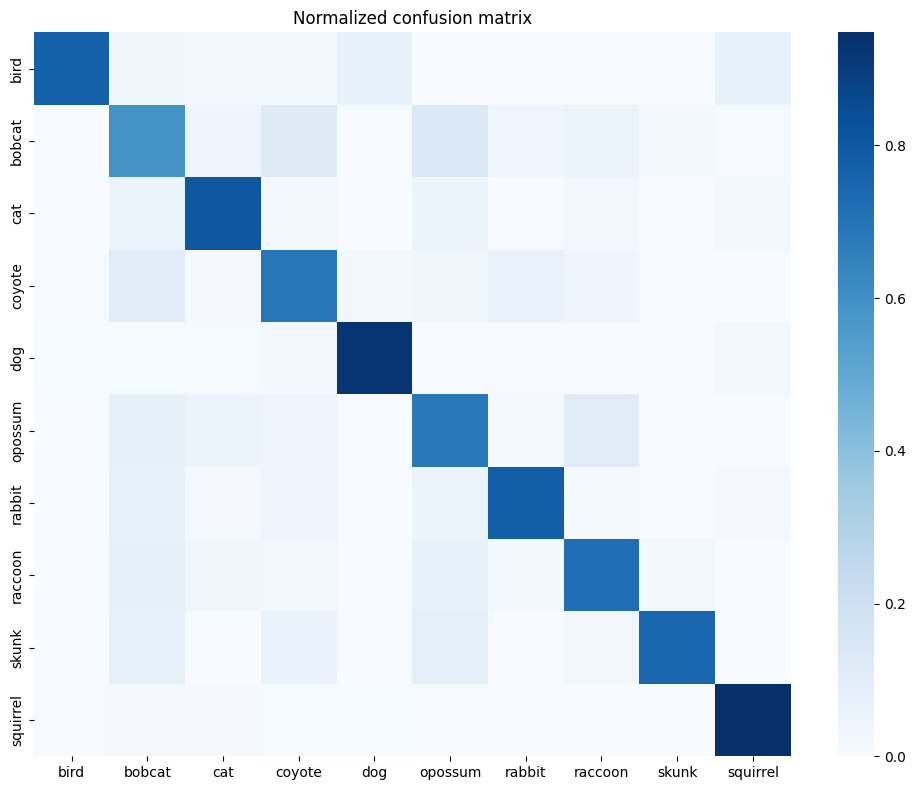

Saved outputs files.


In [19]:
os.makedirs("outputs", exist_ok=True)

cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

#normalized confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm_df = pd.DataFrame(cm_norm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm_df, annot=False, cmap="Blues")
plt.title("Normalized confusion matrix")
plt.tight_layout()
plt.savefig("outputs/confusion_matrix_normalized.png", dpi=200)
plt.show()

cm_df.to_csv("outputs/confusion_matrix.csv")

df_use.to_csv("outputs/subset_metadata.csv", index=False)

print("Saved outputs files.")

In [24]:
from collections import Counter

def top_confusions(df, k=15):
    m = df.dropna(subset=[COL_TRUE, COL_PRED])
    m = m[m[COL_TRUE] != m[COL_PRED]]

    pairs = list(zip(m[COL_TRUE], m[COL_PRED]))
    c = Counter(pairs)
    top = c.most_common(k)

    out = pd.DataFrame(top, columns=["pair", "count"])
    out["true"] = out["pair"].apply(lambda x: x[0])
    out["pred"] = out["pair"].apply(lambda x: x[1])
    out = out.drop(columns=["pair"])
    return out

conf_tbl = top_confusions(DF, k=15)
conf_tbl

,image_id,file_name,species,category_id,location,datetime,abs_path,split
0,59e43ed5-23d2-11e8-a6a3-ec086b02610b,59e43ed5-23d2-11e8-a6a3-ec086b02610b.jpg,bird,11,NaN,None,cct_data/extracted/eccv_18_all_images_sm/59e43...,unknown
1,59087f23-23d2-11e8-a6a3-ec086b02610b,59087f23-23d2-11e8-a6a3-ec086b02610b.jpg,bird,11,100.0,None,cct_data/extracted/eccv_18_all_images_sm/59087...,unknown
2,58f73fe8-23d2-11e8-a6a3-ec086b02610b,58f73fe8-23d2-11e8-a6a3-ec086b02610b.jpg,bird,11,100.0,None,cct_data/extracted/eccv_18_all_images_sm/58f73...,unknown
3,58f5b25a-23d2-11e8-a6a3-ec086b02610b,58f5b25a-23d2-11e8-a6a3-ec086b02610b.jpg,bird,11,78.0,None,cct_data/extracted/eccv_18_all_images_sm/58f5b...,unknown
4,59a499e2-23d2-11e8-a6a3-ec086b02610b,59a499e2-23d2-11e8-a6a3-ec086b02610b.jpg,bird,11,46.0,None,cct_data/extracted/eccv_18_all_images_sm/59a49...,unknown


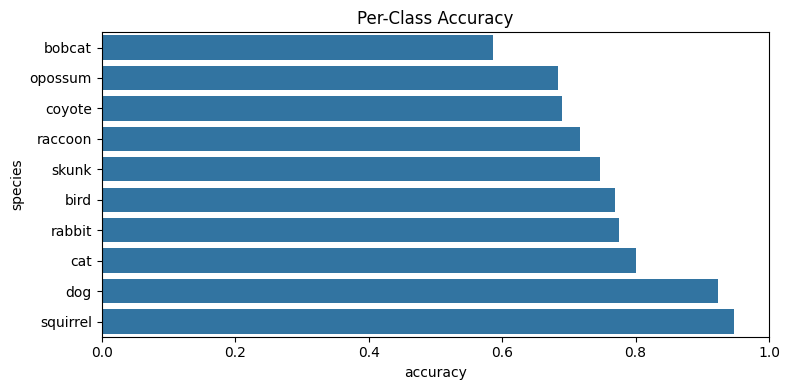

In [29]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

acc_df = pd.DataFrame({
    "species": le.classes_,
    "accuracy": per_class_acc
}).sort_values("accuracy")

plt.figure(figsize=(8,4))
sns.barplot(data=acc_df, x="accuracy", y="species")
plt.title("Per-Class Accuracy")
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("outputs/per_class_accuracy.png", dpi=200)
plt.show()

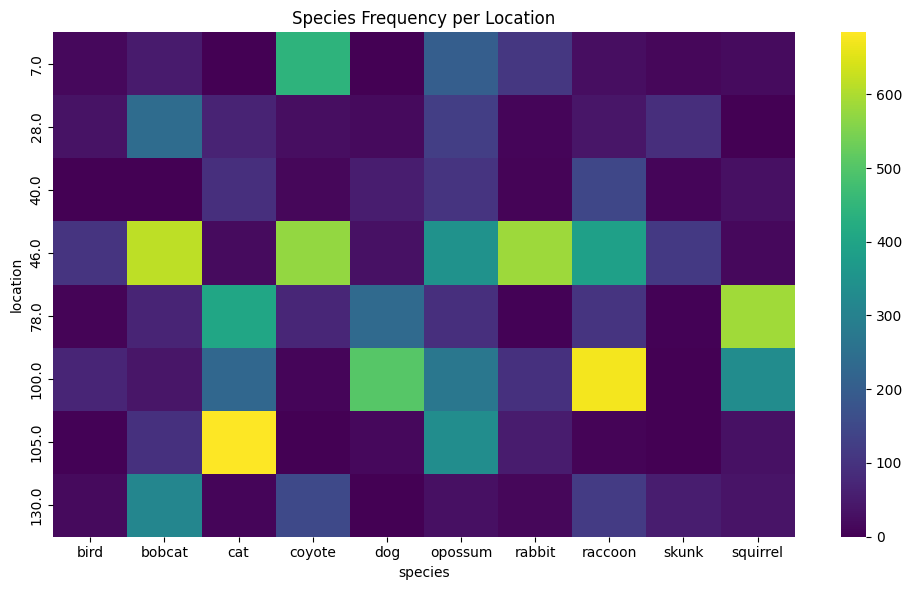

In [30]:
pivot = loc_counts.pivot(index="location", columns="species", values="count").fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Species Frequency per Location")
plt.tight_layout()
plt.savefig("outputs/location_species_heatmap.png", dpi=200)
plt.show()

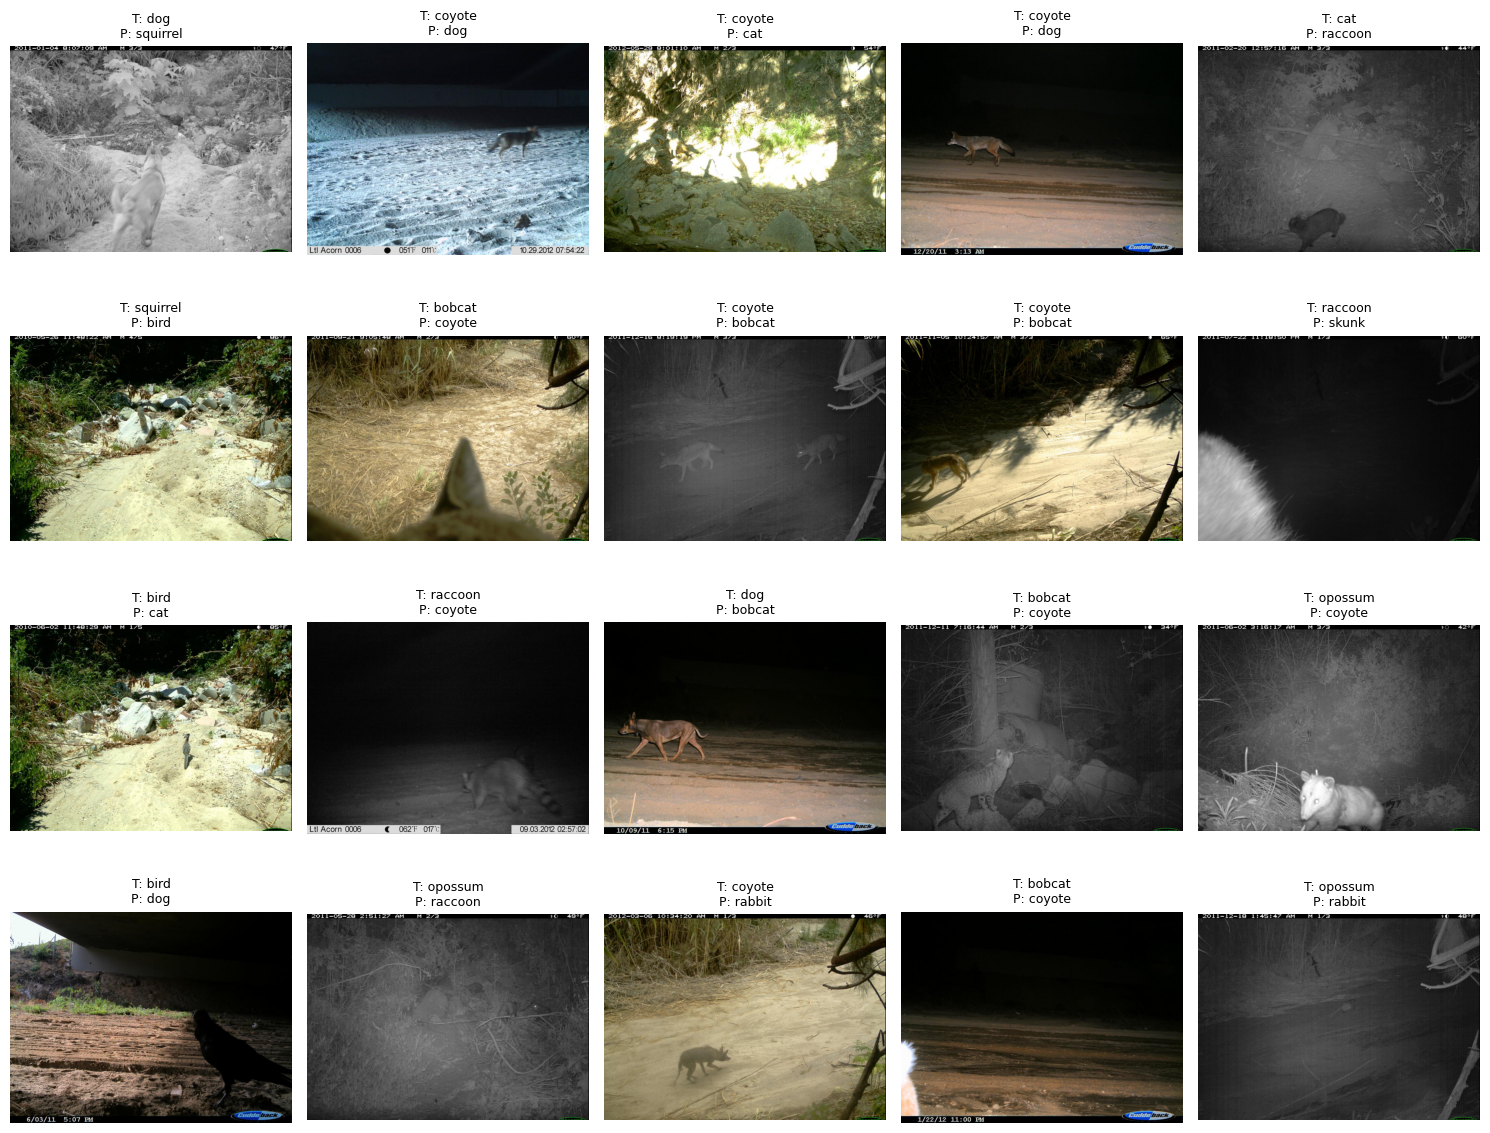

In [35]:
idx_all = np.arange(len(df_use))
_, idx_test = train_test_split(
    idx_all,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

mis_pos = np.where(pred != y_test)[0]

try:
    probs = clf.predict_proba(X_test)
    conf = probs.max(axis=1)
    mis_pos = mis_pos[np.argsort(conf[mis_pos])[::-1]]
except Exception:
    pass

K = 20
mis_pos = mis_pos[:K]

cols = 5
rows = int(np.ceil(len(mis_pos) / cols))
plt.figure(figsize=(cols*3, rows*3))

for j, p in enumerate(mis_pos):
    original_idx = idx_test[p]
    img_path = df_use.iloc[original_idx]["abs_path"]

    true_lbl = le.inverse_transform([y_test[p]])[0]
    pred_lbl = le.inverse_transform([pred[p]])[0]

    ax = plt.subplot(rows, cols, j+1)
    try:
        im = Image.open(img_path).convert("RGB")
        ax.imshow(im)
        ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=9)
    except Exception as e:
        ax.text(0.5, 0.5, f"Failed\n{os.path.basename(img_path)}", ha="center", va="center")
    ax.axis("off")

plt.tight_layout()
plt.show()